In [1309]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [2054]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

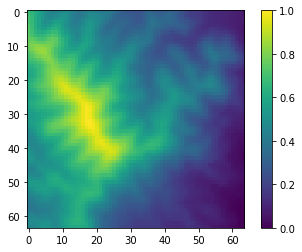

In [2055]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[16].view(64, 64))
plt.colorbar(p)
plt.show()

In [2057]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [2747]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64) 
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 256)
        self.enc_linear_1_2 = nn.Linear(4096, 256)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(256, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(mu.size()).cuda()
        return mu + std * esp
        
    def decode(self, code):
        out = F.leaky_relu(self.dec_linear_1(code))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [2748]:
vae = VAE().cuda()

In [2749]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

RuntimeError: shape '[1, 256, 2, 2]' is invalid for input of size 4096

In [2497]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 50

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
          loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
    print(msg)

epoch[1/50], loss=1.912, MSE=1.742, KLD=0.170
epoch[2/50], loss=1.565, MSE=1.463, KLD=0.102
epoch[3/50], loss=0.972, MSE=0.882, KLD=0.090
epoch[4/50], loss=0.388, MSE=0.315, KLD=0.073
epoch[5/50], loss=0.370, MSE=0.304, KLD=0.065
epoch[6/50], loss=0.828, MSE=0.757, KLD=0.071
epoch[7/50], loss=0.834, MSE=0.769, KLD=0.065
epoch[8/50], loss=0.743, MSE=0.683, KLD=0.061
epoch[9/50], loss=0.411, MSE=0.350, KLD=0.061
epoch[10/50], loss=0.628, MSE=0.570, KLD=0.058
epoch[11/50], loss=0.377, MSE=0.317, KLD=0.060
epoch[12/50], loss=0.415, MSE=0.351, KLD=0.065
epoch[13/50], loss=0.294, MSE=0.239, KLD=0.055
epoch[14/50], loss=0.526, MSE=0.463, KLD=0.063
epoch[15/50], loss=0.502, MSE=0.443, KLD=0.059
epoch[16/50], loss=0.393, MSE=0.341, KLD=0.052
epoch[17/50], loss=0.416, MSE=0.335, KLD=0.081
epoch[18/50], loss=0.293, MSE=0.244, KLD=0.049
epoch[19/50], loss=0.600, MSE=0.548, KLD=0.052
epoch[20/50], loss=0.457, MSE=0.402, KLD=0.055
epoch[21/50], loss=0.359, MSE=0.305, KLD=0.054
epoch[22/50], loss=0.5

In [2498]:
torch.cuda.empty_cache()

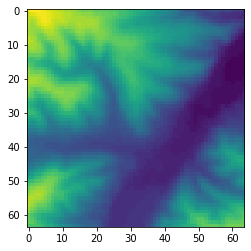

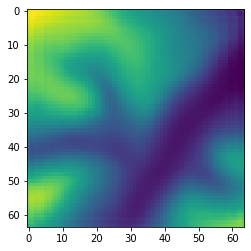

In [2507]:
x = dataset[39990].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [2508]:
#torch.save(vae.state_dict(), './vae256_save')

In [295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

In [2586]:
xs = []
for data in dataset:
    mu, logvar = vae.encode(data.cuda().view(1, 1, 64, 64))
    code = vae.reparametrize(mu, logvar)
    xs.append(code.cpu().detach()[0])

In [2588]:
codes = torch.cat(xs).view(-1, 256)

In [2589]:
mean = codes.mean(axis=0)
std = codes.std(axis=0)

In [2590]:
mean

tensor([ 3.8036e-02,  5.5389e-01,  3.7009e-01, -1.6637e+00,  7.9678e-01,
        -9.7635e-01,  1.1279e-01, -9.2063e-02,  3.9902e-01,  4.1676e-01,
        -6.1056e-01,  1.2941e-01, -1.6563e+00, -8.2433e-02, -2.1620e-02,
        -9.6602e-02,  9.2073e-01, -4.6254e-02,  9.8581e-02,  4.3682e-01,
        -1.0571e+00,  1.9942e-01,  7.8033e-01,  2.6952e-01, -1.1434e+00,
        -1.8999e-01,  9.9231e-01, -6.0998e-01, -4.1585e-01, -7.0050e-01,
         4.5293e-01,  6.3027e-01,  2.7848e-01,  1.2746e+00,  5.7448e-02,
         8.3531e-02, -1.7530e+00,  1.4994e+00,  4.9162e-01, -2.6529e-02,
         1.6261e+00,  3.7448e-01,  1.1693e+00, -1.1151e+00, -7.2319e-04,
        -8.9576e-01, -1.6501e+00,  2.1014e-01,  8.2547e-01,  1.4258e-01,
         1.1221e-01,  3.1045e-01, -1.0894e+00,  1.1588e+00, -7.4628e-01,
        -7.5103e-01, -2.1867e-01,  5.4928e-01, -4.4731e-01,  7.3375e-02,
        -7.5809e-01, -1.3832e+00,  1.0985e-01,  2.4322e-01,  7.5380e-01,
         9.2254e-01, -1.6573e+00,  1.4201e-01, -3.7

In [2591]:
std

tensor([1.7352, 1.0538, 0.9241, 1.6282, 0.9960, 0.7758, 1.7339, 1.0933, 1.1307,
        0.8932, 1.2305, 1.3783, 0.8349, 0.7730, 1.3000, 0.8675, 0.8477, 1.0067,
        1.1713, 1.8116, 1.7703, 1.2342, 0.8993, 0.9521, 0.7016, 0.8791, 0.8612,
        1.3155, 0.9732, 0.9120, 1.1486, 0.8884, 1.0329, 1.3704, 1.4272, 0.8501,
        0.7902, 1.1297, 0.8368, 0.8829, 0.8280, 0.8548, 0.8668, 0.8529, 1.6609,
        1.8816, 1.1404, 1.3586, 1.5369, 0.7593, 1.1265, 1.6573, 1.0737, 0.5230,
        1.0433, 0.9926, 0.7919, 1.4898, 1.0442, 1.1253, 1.1279, 0.9741, 0.8860,
        0.7736, 1.1500, 1.0213, 0.9985, 0.9258, 1.0081, 1.1719, 0.8954, 0.9481,
        1.0188, 1.1327, 0.7141, 1.2525, 1.2429, 0.9032, 0.8983, 0.7253, 1.0193,
        1.1460, 1.1177, 0.9158, 1.2719, 0.8555, 0.7832, 0.8231, 1.0491, 1.5268,
        1.1599, 0.9707, 0.9692, 0.9274, 1.0300, 0.8213, 1.0396, 1.1634, 0.9102,
        0.9711, 0.6818, 1.1158, 1.1604, 0.6842, 0.9923, 1.6506, 0.9915, 0.9916,
        0.8559, 1.2521, 0.8503, 0.9430, 

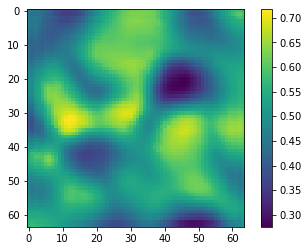

In [2740]:
# Generator
code = torch.FloatTensor(1, 256).normal_()
#code = mean + std * code

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()